In [12]:
import numpy as np
import scipy.sparse as sp
import os
import sys
from vis import plot_superadj

In [13]:
from ogb.nodeproppred import DglNodePropPredDataset
def load_assortative(dataset="cora"):
    import pickle as pkl
    import networkx as nx
    import scipy.sparse as sp
    import torch

    def parse_index_file(filename):
        index = []
        for line in open(filename):
            index.append(int(line.strip()))
        return index

    def sample_mask(idx, l):
        """Create mask."""
        mask = np.zeros(l)
        mask[idx] = 1
        return np.array(mask, dtype=np.bool)

    if dataset in ["cora", "citeseer", "pubmed"]:
        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []

        for i in range(len(names)):
            '''
            fix Pickle incompatibility of numpy arrays between Python 2 and 3
            https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
            '''
            with open("/data/yliumh/AutoAtClusterDatasets/gcn/gcn/data/{}/ind.{}.{}".format(dataset, dataset, names[i]), 'rb') as rf:
                u = pkl._Unpickler(rf)
                u.encoding = 'latin1'
                cur_data = u.load()
                objects.append(cur_data)
            # objects.append(
            #     pkl.load(open("data/ind.{}.{}".format(dataset, names[i]), 'rb')))
        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file(
            "/data/yliumh/AutoAtClusterDatasets/gcn/gcn/data/{}/ind.{}.test.index".format(dataset, dataset))
        test_idx_range = np.sort(test_idx_reorder)


        if dataset == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(
                min(test_idx_reorder), max(test_idx_reorder) + 1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range - min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range - min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        features = torch.FloatTensor(np.array(features.todense()))
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
        
        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]
        
        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y) + 500)

        train_mask = sample_mask(idx_train, labels.shape[0])
        val_mask = sample_mask(idx_val, labels.shape[0])
        test_mask = sample_mask(idx_test, labels.shape[0])

        y_train = np.zeros(labels.shape)
        y_val = np.zeros(labels.shape)
        y_test = np.zeros(labels.shape)
        y_train[train_mask, :] = labels[train_mask, :]
        y_val[val_mask, :] = labels[val_mask, :]
        y_test[test_mask, :] = labels[test_mask, :]

        adj = adj.toarray()
        labels = labels.argmax(1)
        # idx = labels.argsort(0)
        # adj = adj[idx, :][:, idx]
        # labels = labels[idx]
        # features = features[idx]

        adj = sp.coo_matrix(adj)
        features = sp.coo_matrix(features)

        return adj, features, labels
    elif dataset == "wiki":
        f = open('/data/yliumh/AutoAtClusterDatasets/AGE/data/graph.txt','r')
        adj, xind, yind = [], [], []
        for line in f.readlines():
            line = line.split()
            
            xind.append(int(line[0]))
            yind.append(int(line[1]))
            adj.append([int(line[0]), int(line[1])])
        f.close()
        ##print(len(adj))

        f = open('/data/yliumh/AutoAtClusterDatasets/AGE/data/group.txt','r')
        label = []
        for line in f.readlines():
            line = line.split()
            label.append(int(line[1]))
        f.close()

        f = open('/data/yliumh/AutoAtClusterDatasets/AGE/data/tfidf.txt','r')
        fea_idx = []
        fea = []
        adj = np.array(adj)
        adj = np.vstack((adj, adj[:,[1,0]]))
        adj = np.unique(adj, axis=0)
        
        labelset = np.unique(label)
        labeldict = dict(zip(labelset, range(len(labelset))))
        label = np.array([labeldict[x] for x in label])
        adj = sp.coo_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

        for line in f.readlines():
            line = line.split()
            fea_idx.append([int(line[0]), int(line[1])])
            fea.append(float(line[2]))
        f.close()

        fea_idx = np.array(fea_idx)
        features = sp.coo_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
        scaler = preprocessing.MinMaxScaler()
        #features = preprocess.normalize(features, norm='l2')
        features = scaler.fit_transform(features)
        # features = torch.FloatTensor(features)
        features = sp.coo_matrix(features)

        return adj, features, label
    elif dataset in ["ogbn-arxiv", "ogbn-products"]:
        dataset = DglNodePropPredDataset(name="{}".format(dataset))
        g, labels = dataset[0]
        # edge_indices = g.adj_sparse(fmt="coo")
        edge_indices = g.adj().indices()
        n, m = labels.shape[0], edge_indices[0].shape[0]
        adj = sp.coo_matrix((np.ones(m), (edge_indices[0].numpy(), edge_indices[1].numpy())), shape=(n,n))
        features = g.ndata["feat"]
        features = sp.coo_matrix(features)

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)
        labels = labels.numpy()
        return adj, features, labels
    elif dataset in ["amazon-photo", "amazon-computers", "cora-full"]:
        map2names = {
            "amazon-photo": "/data/yliumh/AutoAtClusterDatasets/gnn-benchmark/data/npz/amazon_electronics_photo.npz",
            "amazon-computers": "/data/yliumh/AutoAtClusterDatasets/gnn-benchmark/data/npz/amazon_electronics_computers.npz",
            "cora-full": "/data/yliumh/AutoAtClusterDatasets/gnn-benchmark/data/npz/cora_full.npz",
        }

        data = np.load(map2names[dataset])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels
    else:
        raise NotImplementedError()

In [14]:
dataset = "cora-full"

In [15]:
adj_raw, features_raw, labels_raw = load_assortative(dataset)

In [16]:
import inspect
lines = inspect.getsource(plot_superadj)
print(lines)

def plot_superadj(adj, K=100, sparse=True, labels=None, dataset="", vline=False):
    if labels is not None:
        idx = np.argsort(labels, 0)
        if sparse:
            # adj = reorder_sparse(adj, idx)
            adj = reorder_sparse_coo(adj, idx)
        else:
            adj = adj[idx, :][:, idx]
    n = adj.shape[0]

    adj = superPixels(adj, K, sparse=sparse)
    plt.figure()
    ax = plt.gca()
    plt.imshow(adj, cmap="coolwarm")
    plt.colorbar()
    if labels is not None and vline:
        labels = np.array(labels, dtype=int)
        labels = np.sort(labels)
        minl, maxl = labels[0], labels[-1]
        xs = []
        for l in range(minl+1, maxl+1):
            idx = np.searchsorted(labels, l)
            xs.append(idx)
        unit = n // K
        xs = [x / unit for x in xs]
        for x in xs:
            plt.axvline(x=x, color="red")
    # plt.clim(0.0, 0.04)
    os.makedirs("pics", exist_ok=True)
    plt.savefig("pics/adj_{}.png".format(dataset))



100%|█████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.97it/s]


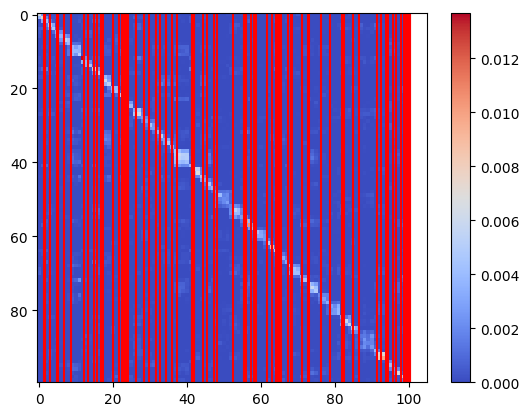

In [17]:
plot_superadj(adj_raw, K=100, sparse=True, labels=labels_raw, dataset=dataset, vline=True)

In [7]:
labels_s = np.sort(np.unique(labels_raw))
nclass = labels_s.shape[0]
node_sizes = []
for cls_id in labels_s:
    node_sizes.append(np.where(labels_raw==cls_id)[0].shape[0])
node_sizes = np.array(node_sizes)

print("Number of Nodes: {}".format(adj_raw.shape[0]))
print("Number of Edges: {}".format(adj_raw.sum()))
print("Dim of features: {}".format(features_raw.shape[-1]))
print("Number of Classes: {}".format(nclass))
print("Number of nodes in each class: {}".format(node_sizes))

Number of Nodes: 169343
Number of Edges: 1166243.0
Dim of features: 128
Number of Classes: 40
Number of nodes in each class: [  565   687  4839  2080  5862  4958  1618   589  6232  2820  7869   750
    29  2358   597   403 27321   515   749  2877  2076   393  1903  2834
 22187  1257  4605  4801 21406   416 11814  2828   411  1271  7867   127
  3524  2369  1507  2029]


In [8]:
print(500, (np.array(node_sizes)>=500).sum())
print(1000, (np.array(node_sizes)>=1000).sum())
print(2000, (np.array(node_sizes)>=2000).sum())
print(3000, (np.array(node_sizes)>=3000).sum())
print(4000, (np.array(node_sizes)>=4000).sum())

500 34
1000 27
2000 22
3000 13
4000 12


In [9]:
def sample_classes(adj, features, labels, rate=0.1, seed=None):
    n, d = features.shape
    labels_s = np.sort(np.unique(labels))
#     print(labels_s)
    nclass = labels_s.shape[0]
    assert nclass > 1
    
    mask = np.zeros(n)
    for cls_id in labels_s:
        # exist_prob = rate + (1.0 - rate) / (nclass-1) * cls_id
        exist_prob = rate # Set same prob to each class
        node_ids = np.where(labels==cls_id)[0]
        n_ = node_ids.shape[0]
#         print(n_)
        mask_ = np.random.RandomState(seed=seed).binomial(1, exist_prob, size=(n_))
        
        mask[node_ids] = mask_
    
    mask = np.nonzero(mask)[0]
    
    adj = adj.toarray()[mask, :][:, mask]
    adj = sp.coo_matrix(adj)
    features = features.toarray()[mask]
    features = sp.coo_matrix(features)
    labels = labels[mask]

    mask = [v for v in mask]
    
    return adj, features, labels, mask

In [10]:
rate = 0.1
nseeds = 10
for seed in range(nseeds):
    adj_s, features_s, labels_s, mask = sample_classes(adj_raw, features_raw, labels_raw, rate=rate, seed=seed)
    print(adj_s.shape, adj_s.sum())
#     plot_superadj(adj_s2, K=100, sparse=False, labels=labels_s2, dataset=dataset+"_{}".format(rention_rate), vline=True)
    np.savez("dataset/{}_{:.1f}_{:d}_kd.npz".format(dataset, rate, seed), data=adj_s.data, row=adj_s.row, col=adj_s.col, features=features_s.toarray(), labels=labels_s, mask=mask)

(17618, 17618) 11495.0
(16819, 16819) 11762.0
(17124, 17124) 13817.0
(17045, 17045) 11532.0
(17609, 17609) 11339.0
(17056, 17056) 12535.0
(17094, 17094) 10816.0
(16850, 16850) 14591.0
(16127, 16127) 11631.0
(16572, 16572) 10741.0


100%|█████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.60it/s]


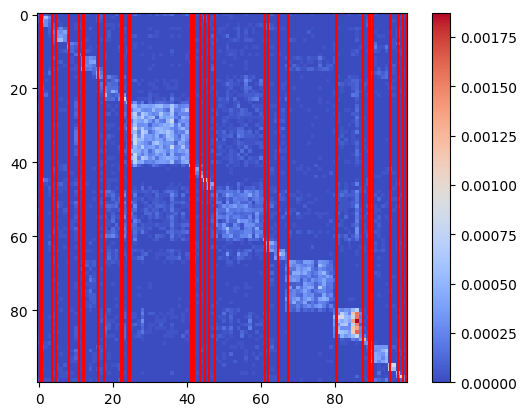

In [11]:
plot_superadj(adj_s, K=100, sparse=True, labels=labels_s, dataset=dataset, vline=True)